In [383]:
import pandas as pd
import numpy as np
import math
from itertools import cycle
import statistics
import shap


#from datetime import datetime
import datetime

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from matplotlib import style
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns
import shap

from scipy.stats import randint, uniform, shapiro
import scikitplot as skplt
import sklearn as sk
from sklearn import linear_model

from sklearn.compose import make_column_transformer, ColumnTransformer
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.model_selection import KFold, cross_val_score, cross_val_predict
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, RobustScaler, Normalizer, PowerTransformer, OneHotEncoder
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import AdaBoostRegressor, RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
import lightgbm as ltb
import xgboost as xgb

import statsmodels.api as sm
import statsmodels
from statsmodels.tools import eval_measures

from sklearn import metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

from fredapi import Fred
import pandas_datareader as pdr

import warnings

In [384]:
sk.set_config(display='diagram')
warnings.filterwarnings("ignore")
shap.initjs()

# Plotting using Seaborn
sns.set(style="whitegrid")
style.use("seaborn-white")

In [385]:
fred = Fred(api_key='c0a3f23bdd23a65e6546b6d0e5f4d4a5')

In [386]:
from common.load_features import get_recession, add_recession_feature, get_fed_chair, add_fed_chair
from common.load_data import load_taylor,load_misery, time_split
from common.calc_metrics import model_results
from common.LinearRegDiagnostic import LinearRegDiagnostic

# Setup

## variables

In [387]:
rand_int = 12

#  Set start date
start_date = datetime.date(1940, 1, 1)
start_date_str = datetime.datetime.strftime(start_date, "%Y-%m-%d")

#  Federal Reserve Economic Data Service
data_source = 'fred'

# Functions

In [388]:
t0_df = load_taylor()
train0_df, test0_df = time_split(t0_df)

model_stats_df = model_results('ffef_tr_test', train0_df['FEDFUNDS'], train0_df['ffef_tr'], train0_df.shape[0], 2  , None )
model_stats_df = model_results('ffef_tr_test', test0_df['FEDFUNDS'], test0_df['ffef_tr'], test0_df.shape[0], 2  , model_stats_df )

model_stats_df = model_results('ffef_tr2_test', train0_df['FEDFUNDS'], train0_df['ffef_tr2'], train0_df.shape[0], 2  , model_stats_df )
model_stats_df = model_results('ffef_tr2_test', test0_df['FEDFUNDS'], test0_df['ffef_tr2'], test0_df.shape[0], 2  , model_stats_df )

model_stats_df = model_results('Naive_test', train0_df['FEDFUNDS'], train0_df['FEDFUNDS-1'], train0_df.shape[0], 1  , model_stats_df )
model_stats_df = model_results('Naive_test', test0_df['FEDFUNDS'], test0_df['FEDFUNDS-1'], test0_df.shape[0], 1  , model_stats_df )

model_stats_df

t1_df: (1006, 4)
gdpc1_df: (305, 2)
gdppot_df: (304, 2)
gdpdef_df: (302, 2)
cpi_df: (909, 2)
holston_df: (250, 4)
train_df:  (200, 19)
test_df:  (50, 19)


,name,r_sq,adj_r_sq,mse,rmse
0,ffef_tr_test,-1.1459,-1.1568,25.0445,5.0044
1,ffef_tr_test,-40.4673,-41.3312,56.7392,7.5325
2,ffef_tr2_test,0.9079,0.9074,1.0753,1.0369
3,ffef_tr2_test,0.7806,0.7760,0.3002,0.5479
4,Naive_test,0.9206,0.9206,0.9263,0.9624
5,Naive_test,0.8830,0.8830,0.1601,0.4002


# Load Data

In [389]:
taylor_df = load_taylor()
train_df, test_df = time_split(taylor_df)

t1_df: (1006, 4)
gdpc1_df: (305, 2)
gdppot_df: (304, 2)
gdpdef_df: (302, 2)
cpi_df: (909, 2)
holston_df: (250, 4)
train_df:  (200, 19)
test_df:  (50, 19)


In [390]:
#taylor_df['chair_name'].unique()
taylor_df

,FEDFUNDS,UNRATE,TB3MS,GDPC1,GDPPOT,GDPDEF_PC1,CPIAUCSL_PC1,Growth_g,Real_Interest_Rate,Output_Gap,FEDFUNDS-1,gap_inf,gap_gdp,gap_ue,ffef_tr,ffef_tr2,recession_flag,chair_name,chair_index
DATE,,,,,,,,,,,,,,,,,,,
1961-03-31,2.003333,6.800000,2.350000,3493.703,3385.151548,1.1,1.508150,4.828759,5.493491,-3.755573,2.296667,-0.491850,3.206694,-1.800000,4.457422,2.938524,False,Martin,8
1961-06-30,1.733333,7.000000,2.303333,3553.021,3414.679709,1.1,0.867953,4.989798,5.682399,-3.407557,2.003333,-1.132047,4.051369,-2.000000,4.559661,2.570483,False,Martin,8
1961-09-30,1.683333,6.766667,2.303333,3621.252,3445.236389,1.0,1.205397,4.923091,5.609036,-2.640213,1.733333,-0.794603,5.108956,-1.766667,5.157176,2.409403,False,Martin,8
1961-12-31,2.400000,6.200000,2.460000,3692.289,3476.671046,1.0,0.705207,4.910719,5.592011,-1.931028,1.683333,-1.294793,6.201851,-1.200000,5.453529,2.260306,False,Martin,8
1962-03-31,2.456667,5.633333,2.723333,3758.147,3510.589803,1.3,0.893657,4.767864,5.431519,-1.116593,2.400000,-1.106343,7.051727,-0.633333,6.272692,2.896301,False,Martin,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-06-30,0.770000,3.600000,1.076667,21708.160,20153.810000,7.7,8.554363,1.728947,0.666278,4.479321,0.120000,6.554363,7.712437,1.400000,16.833400,1.997673,False,Powell,15
2022-09-30,2.190000,3.566667,2.663333,21851.134,20245.660000,7.3,8.285130,1.850930,0.785472,4.164357,0.770000,6.285130,7.929966,1.433333,16.407548,2.507975,False,Powell,15
2022-12-31,3.653333,3.600000,4.040000,21989.981,20334.210000,6.4,7.114260,1.825866,0.717093,4.018788,2.190000,5.114260,8.142785,1.400000,15.028522,3.440772,False,Powell,15


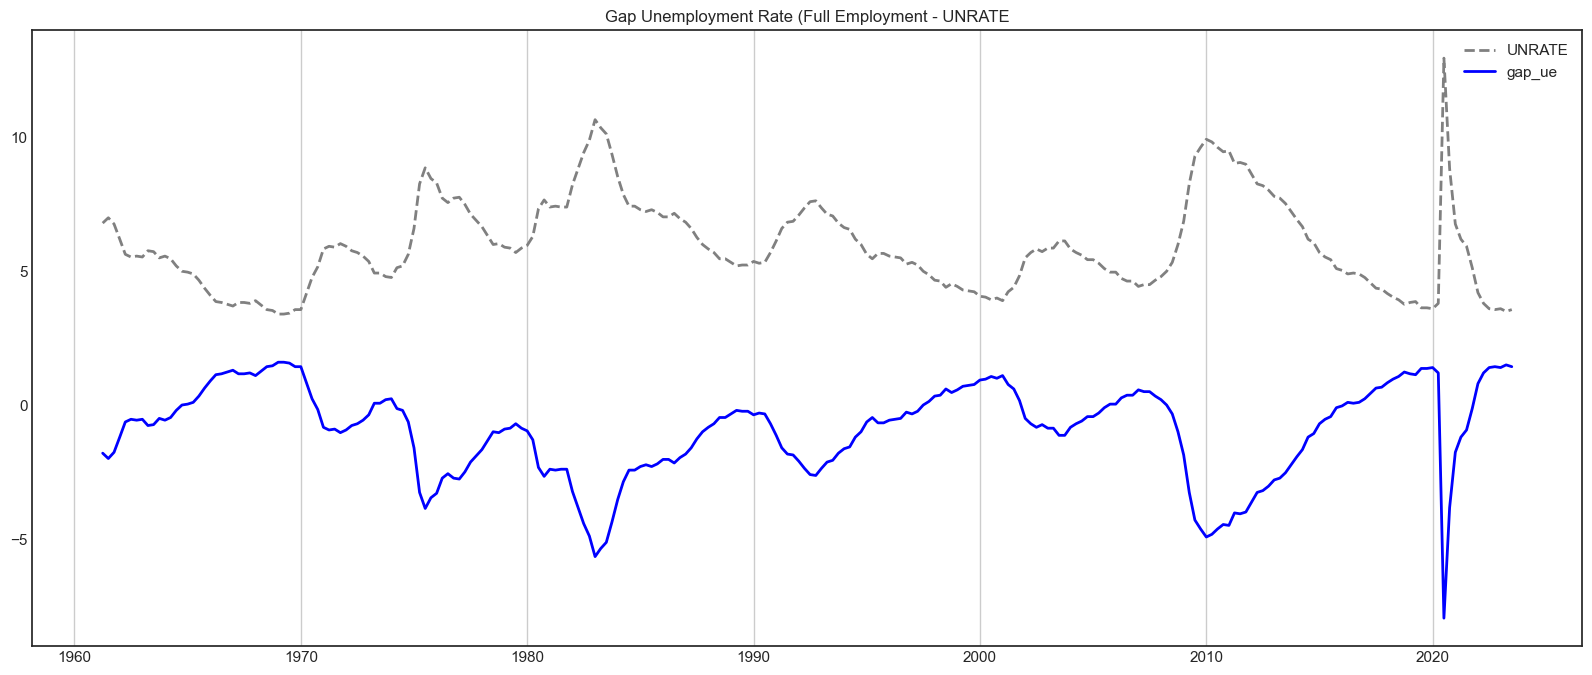

In [391]:
# Graph
fig, ax = plt.subplots(figsize=(20,8))
ax.xaxis.grid()

# Plot
ax.plot(taylor_df.index, taylor_df['UNRATE'], 'gray', linestyle='--', linewidth=2)
ax.plot(taylor_df.index, taylor_df['gap_ue'], 'blue', linewidth=2)
ax.legend(["UNRATE","gap_ue"])
ax.set(title='Gap Unemployment Rate (Full Employment - UNRATE');
plt.show()

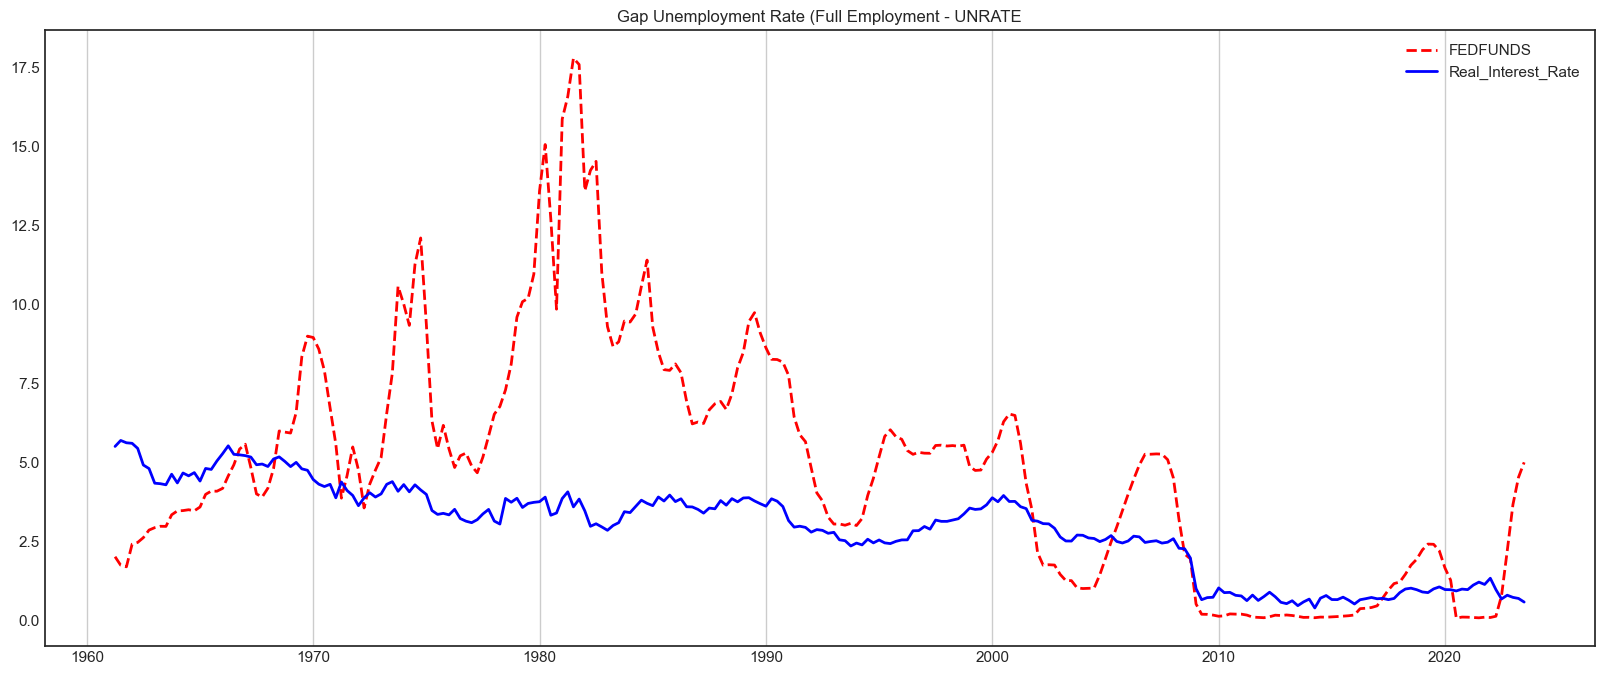

In [392]:
# Graph
fig, ax = plt.subplots(figsize=(20,8))
ax.xaxis.grid()

# Plot
ax.plot(taylor_df.index, taylor_df['FEDFUNDS'], 'red', linestyle='--', linewidth=2)
ax.plot(taylor_df.index, taylor_df['Real_Interest_Rate'], 'blue', linewidth=2)
ax.legend(["FEDFUNDS","Real_Interest_Rate"])
ax.set(title='Gap Unemployment Rate (Full Employment - UNRATE');
plt.show()

In [393]:
#case = 1  # Taylor Rule
#case = 2  # -UNRATE and Real_Interest_Rate and CPIAUCSL_PC1
#case = 3  # -UNRATE and Real_Interest_Rate
case = None  # Extened Taylor Rule

# Initialize Variables
X_train = None
y_train = None
X_test = None
y_test = None

# Initialize Imputer
preprocessor = None




if case == 1:
    print('-- Modified Taylor Rule')
    X_train = train_df[['gap_inf','gap_ue','gap_gdp','FEDFUNDS-1']]
    y_train = train_df['FEDFUNDS']

    X_test = test_df[['gap_inf', 'gap_ue','gap_gdp','FEDFUNDS-1']]
    y_test = test_df['FEDFUNDS']


    # Initialize Imputer
    imp_num = SimpleImputer(missing_values=np.nan, strategy='mean')

    # Initialize Transformer / OneHotEncoder
    num_columns_lst = ['gap_inf', 'gap_ue','gap_gdp','FEDFUNDS-1']
    numeric_transformer = Pipeline(steps = [('imp_num',imp_num)])

    preprocessor = ColumnTransformer(
        transformers=[
            ("num", numeric_transformer, num_columns_lst),
        ]
    )
elif case == 2:
    print('-- Modified Taylor Rule')
    X_train = train_df[['gap_inf','gap_ue','Real_Interest_Rate','FEDFUNDS-1']]
    y_train = train_df['FEDFUNDS']

    X_test = test_df[['gap_inf', 'gap_ue','Real_Interest_Rate','FEDFUNDS-1']]
    y_test = test_df['FEDFUNDS']


    # Initialize Imputer
    imp_num = SimpleImputer(missing_values=np.nan, strategy='mean')

    # Initialize Transformer / OneHotEncoder
    num_columns_lst = ['gap_inf', 'gap_ue','Real_Interest_Rate','FEDFUNDS-1']
    numeric_transformer = Pipeline(steps = [('imp_num',imp_num)])

    preprocessor = ColumnTransformer(
        transformers=[
            ("num", numeric_transformer, num_columns_lst),
        ]
    )
elif case == 3:
    print('-- (-UNRATE and Real_Interest_Rate and CPIAUCSL_PC1)')
    X_train = train_df[['gap_inf', 'gap_gdp','gap_ue','recession_flag','FEDFUNDS-1']]
    y_train = train_df['FEDFUNDS']


    X_test = test_df[['gap_inf', 'gap_gdp','gap_ue','recession_flag','FEDFUNDS-1']]
    y_test = test_df['FEDFUNDS']


    # Initialize Imputer
    imp_num = SimpleImputer(missing_values=np.nan, strategy='mean')

    # Initialize Transformer / OneHotEncoder
    cat_columns_lst = ['recession_flag']
    num_columns_lst = ['gap_inf', 'gap_gdp','gap_ue','FEDFUNDS-1']


    ohe_categories = list()
    for c in cat_columns_lst:
        ohe_categories.append(list(X_train[c].unique()))

    ohe = OneHotEncoder(categories=ohe_categories, drop='first',
                       sparse_output=False, handle_unknown='ignore')

    transformer = make_column_transformer((ohe, cat_columns_lst), remainder='drop')


    numeric_transformer = Pipeline(steps = [('imp_num',imp_num)])
    categorical_transformer = Pipeline( steps=[('transformer',transformer)])


    preprocessor = ColumnTransformer(
        transformers=[
            ("num", numeric_transformer, num_columns_lst),
            ("cat", categorical_transformer, cat_columns_lst),
        ]
    )
elif case == 4:
    print('-- (-UNRATE and Real_Interest_Rate)')
    X_train = train_df[['gap_inf', 'gap_gdp','gap_ue','CPIAUCSL_PC1','recession_flag','FEDFUNDS-1']]
    y_train = train_df['FEDFUNDS']


    X_test = test_df[['gap_inf', 'gap_gdp','gap_ue','CPIAUCSL_PC1','recession_flag','FEDFUNDS-1']]
    y_test = test_df['FEDFUNDS']


    # Initialize Imputer
    imp_num = SimpleImputer(missing_values=np.nan, strategy='mean')

    # Initialize Transformer / OneHotEncoder
    cat_columns_lst = ['recession_flag']
    num_columns_lst = ['gap_inf', 'gap_gdp','gap_ue','CPIAUCSL_PC1','FEDFUNDS-1']


    ohe_categories = list()
    for c in cat_columns_lst:
        ohe_categories.append(list(X_train[c].unique()))

    ohe = OneHotEncoder(categories=ohe_categories, drop='first',
                       sparse_output=False, handle_unknown='ignore')

    transformer = make_column_transformer((ohe, cat_columns_lst), remainder='drop')


    numeric_transformer = Pipeline(steps = [('imp_num',imp_num)])
    categorical_transformer = Pipeline( steps=[('transformer',transformer)])


    preprocessor = ColumnTransformer(
        transformers=[
            ("num", numeric_transformer, num_columns_lst),
            ("cat", categorical_transformer, cat_columns_lst),
        ]
    )
else:
    print('-- All Variables')
    X_train = train_df[['gap_inf', 'gap_gdp','gap_ue','Real_Interest_Rate','CPIAUCSL_PC1','UNRATE','recession_flag','FEDFUNDS-1']]
    y_train = train_df['FEDFUNDS']


    X_test = test_df[['gap_inf', 'gap_gdp','gap_ue','Real_Interest_Rate','CPIAUCSL_PC1','UNRATE','recession_flag','FEDFUNDS-1']]
    y_test = test_df['FEDFUNDS']


    # Initialize Imputer
    imp_num = SimpleImputer(missing_values=np.nan, strategy='mean')

    # Initialize Transformer / OneHotEncoder
    cat_columns_lst = ['recession_flag']
    num_columns_lst = ['gap_inf', 'gap_gdp','gap_ue','Real_Interest_Rate','CPIAUCSL_PC1','UNRATE','FEDFUNDS-1']


    ohe_categories = list()
    for c in cat_columns_lst:
        ohe_categories.append(list(X_train[c].unique()))

    ohe = OneHotEncoder(categories=ohe_categories, drop='first',
                       sparse_output=False, handle_unknown='ignore')

    transformer = make_column_transformer((ohe, cat_columns_lst), remainder='drop')


    numeric_transformer = Pipeline(steps = [('imp_num',imp_num)])
    categorical_transformer = Pipeline( steps=[('transformer',transformer)])


    preprocessor = ColumnTransformer(
        transformers=[
            ("num", numeric_transformer, num_columns_lst),
            ("cat", categorical_transformer, cat_columns_lst),
        ]
    )

-- All Variables


In [394]:
t_fit = preprocessor.fit(X_train)
t_fit.get_feature_names_out()
X_train_trf = t_fit.transform(X_train)

#X_train_trf.columns = 
X_train_trf = pd.DataFrame(X_train_trf)
X_train_trf.columns = t_fit.get_feature_names_out()
X_train_trf['DATE'] = y_train.index
X_train_trf.set_index('DATE', inplace=True)

print('X_train_trf: ', X_train_trf.shape)

X_train_trf:  (200, 8)


# Stats Model - Taylor Index

In [395]:
X_train_const = sm.add_constant(X_train_trf)

In [396]:
ols_model = sm.OLS(y_train, X_train_const)
ols_result = ols_model.fit()

ols_result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               FEDFUNDS   R-squared:                       0.940
Model:                            OLS   Adj. R-squared:                  0.938
Method:                 Least Squares   F-statistic:                     505.2
Date:                Sun, 26 Nov 2023   Prob (F-statistic):          4.20e-115
Time:                        18:24:57   Log-Likelihood:                -247.92
No. Observations:                 200   AIC:                             509.8
Df Residuals:                     193   BIC:                             532.9
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
===========================================================================================================
                                              coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------
const                                      -0.1077      0.046     -2.363      0.019      -0.198      -0.018
num__gap_inf                                0.1655      0.046      3.626      0.000       0.075       0.255
num__gap_gdp                                0.1982      0.056      3.510      0.001       0.087       0.310
num__gap_ue                                -0.3457      0.157     -2.196      0.029      -0.656      -0.035
num__Real_Interest_Rate                    -0.0088      0.076     -0.115      0.908      -0.159       0.142
num__CPIAUCSL_PC1                          -0.0500      0.051     -0.982      0.327      -0.150       0.050
num__UNRATE                                -0.1930      0.073     -2.647      0.009      -0.337      -0.049
num__FEDFUNDS-1                             0.9235      0.029     32.231      0.000       0.867       0.980
cat__onehotencoder__recession_flag_True    -0.7000      0.209     -3.346      0.001      -1.113      -0.287
==============================================================================
Omnibus:                       63.041   Durbin-Watson:                   1.818
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              869.968
Skew:                           0.720   Prob(JB):                    1.23e-189
Kurtosis:                      13.115   Cond. No.                     8.18e+16
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 4.81e-30. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [397]:
train_pred = ols_result.predict(X_train_const)

t = ols_result.get_prediction(X_train_const)
train_pred_ols = t.summary_frame(alpha=0.05)

In [398]:
model_stats_df = model_results('ols_train', y_train, train_pred_ols['mean'], X_train.shape[0], X_train.shape[1] , model_stats_df )

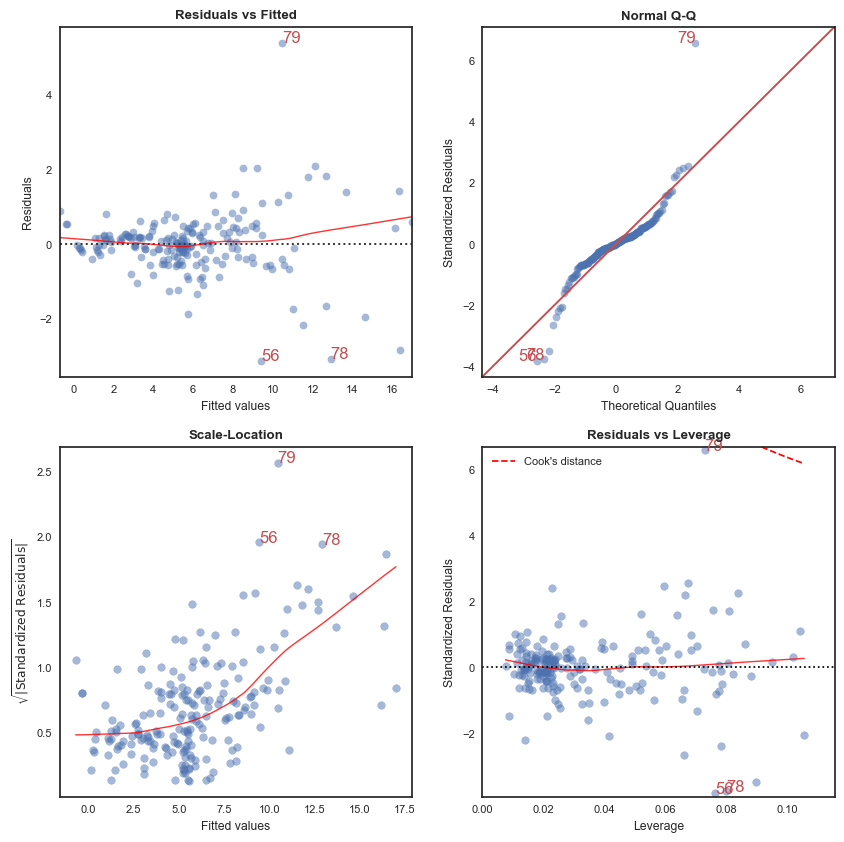

                                  Features  VIF Factor
0                                    const    0.000000
1                             num__gap_inf         inf
2                             num__gap_gdp    5.640890
3                              num__gap_ue         inf
4                  num__Real_Interest_Rate    1.632467
5                        num__CPIAUCSL_PC1         inf
6                              num__UNRATE         inf
7                          num__FEDFUNDS-1    2.625257
8  cat__onehotencoder__recession_flag_True    1.411757


In [399]:
cls = LinearRegDiagnostic(ols_result)
vif, fig, ax = cls()
print(vif)

In [400]:
# Get the residuals from the fitted model
residuals = ols_result.resid

# Perform Shapiro-Wilk test for normality
shapiro_test = shapiro(residuals)

# Display the Shapiro-Wilk test statistic and p-value
print("Shapiro-Wilk Test Statistic:", shapiro_test.statistic)
print("Shapiro-Wilk p-value:", round(shapiro_test.pvalue,6))

Shapiro-Wilk Test Statistic: 0.8525233864784241
Shapiro-Wilk p-value: 0.0


## Test

In [401]:
X_test_trf = t_fit.transform(X_test)

X_test_trf = pd.DataFrame(X_test_trf)
X_test_trf.columns = t_fit.get_feature_names_out()
X_test_trf['DATE'] = y_test.index
X_test_trf.set_index('DATE', inplace=True)

X_test_const = sm.add_constant(X_test_trf)
print('X_test_const: ', X_test_const.shape)

X_test_const:  (50, 9)


In [402]:
t = ols_result.get_prediction(X_test_const)
test_pred_ols = t.summary_frame(alpha=0.05)
test_pred_ols.shape

(50, 6)

In [403]:
model_stats_df = model_results('ols_test', y_test, test_pred_ols['mean'], X_test.shape[0], X_test.shape[1] , model_stats_df )

# Lasso

In [404]:
# Lasso with 5 fold cross-validation
model = linear_model.LassoCV(cv=5, random_state=rand_int, max_iter=10000)

# Fit model
model.fit(X_train_trf, y_train)

print('model.alpha_: ', model.alpha_)

model.alpha_:  0.011159360333333333


In [405]:
lasso_best = linear_model.Lasso(alpha=model.alpha_)
lasso_best.fit(X_train_trf, y_train)

train_pred_lasso = lasso_best.predict(X_train_trf)

In [406]:
feature_df = pd.DataFrame(lasso_best.coef_, t_fit.get_feature_names_out())
feature_df.columns = ['coef']
feature_df.sort_values(by=['coef'], key=pd.Series.abs , ascending=False , inplace=True)
feature_df

,coef
num__FEDFUNDS-1,0.919896
cat__onehotencoder__recession_flag_True,-0.590852
num__gap_gdp,0.187166
num__gap_ue,-0.136329
num__gap_inf,0.102406
num__CPIAUCSL_PC1,0.010117
num__UNRATE,0.000291
num__Real_Interest_Rate,-0.000000


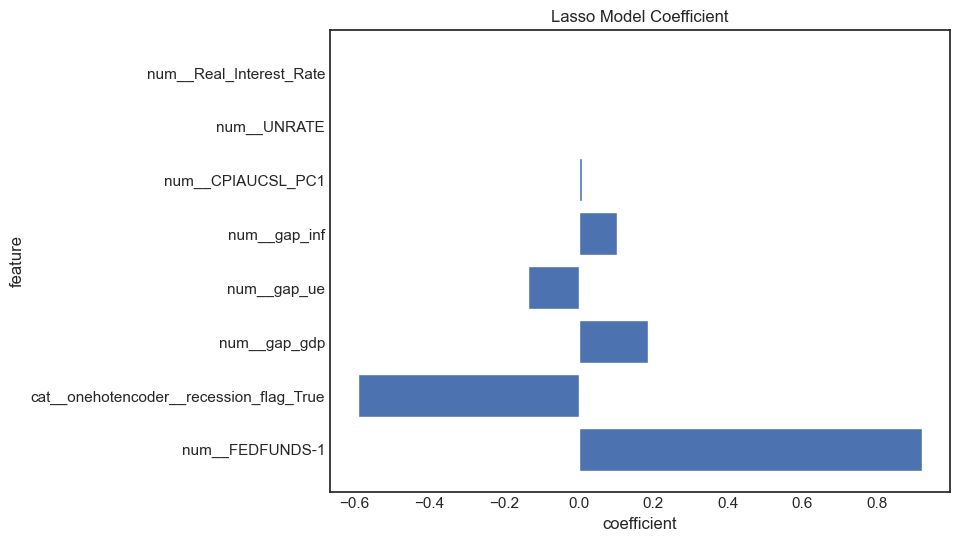

In [407]:
# Plot the MSE values against alphas
plt.figure(figsize=(8, 6))
plt.barh(feature_df.index, feature_df['coef'])

#plt.legend()
plt.xlabel('coefficient')
plt.ylabel('feature')
plt.title('Lasso Model Coefficient')
plt.grid(False)
plt.show()

In [408]:
model_stats_df = model_results('lasso_train', y_train, train_pred_lasso, X_train.shape[0], 2 , model_stats_df )

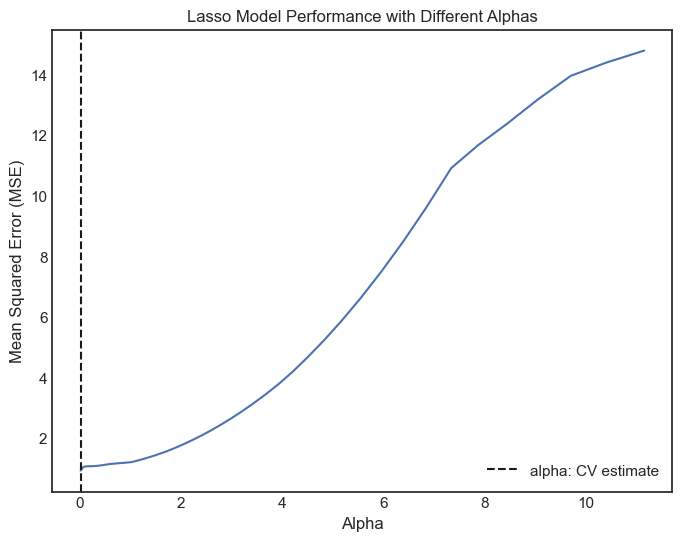

In [409]:
mse_values = np.mean(model.mse_path_, axis=1)

# Plot the MSE values against alphas
plt.figure(figsize=(8, 6))
plt.plot(model.alphas_, mse_values)

plt.axvline(
    model.alpha_, linestyle="--", color="k", label="alpha: CV estimate"
)
plt.legend()
plt.xlabel('Alpha')
plt.ylabel('Mean Squared Error (MSE)')
plt.title('Lasso Model Performance with Different Alphas')
plt.grid(False)
plt.show()

(-0.5462506883166672,
 11.716770381983334,
 -1.3534434657961731,
 30.89099952019664)

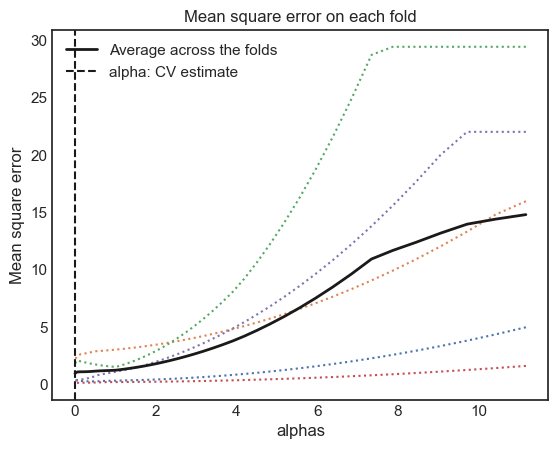

In [410]:
#plt.semilogx(model.alphas_, model.mse_path_, ":")
plt.plot(model.alphas_, model.mse_path_, ":")
plt.plot(
    model.alphas_ ,
    model.mse_path_.mean(axis=-1),
    "k",
    label="Average across the folds",
    linewidth=2,
)
plt.axvline(
    model.alpha_, linestyle="--", color="k", label="alpha: CV estimate"
)

plt.legend()
plt.xlabel("alphas")
plt.ylabel("Mean square error")
plt.title("Mean square error on each fold")
plt.axis("tight")

#ymin, ymax = 50000, 250000
#plt.ylim(ymin, ymax);

In [411]:
test_pred_lasso = lasso_best.predict(X_test_trf)
print('test_pred_lasso: ', test_pred_lasso.shape)

test_pred_lasso:  (50,)


In [412]:
model_stats_df = model_results('lasso_test', y_test, test_pred_lasso, X_test_trf.shape[0], X_test_trf.shape[1] , model_stats_df )

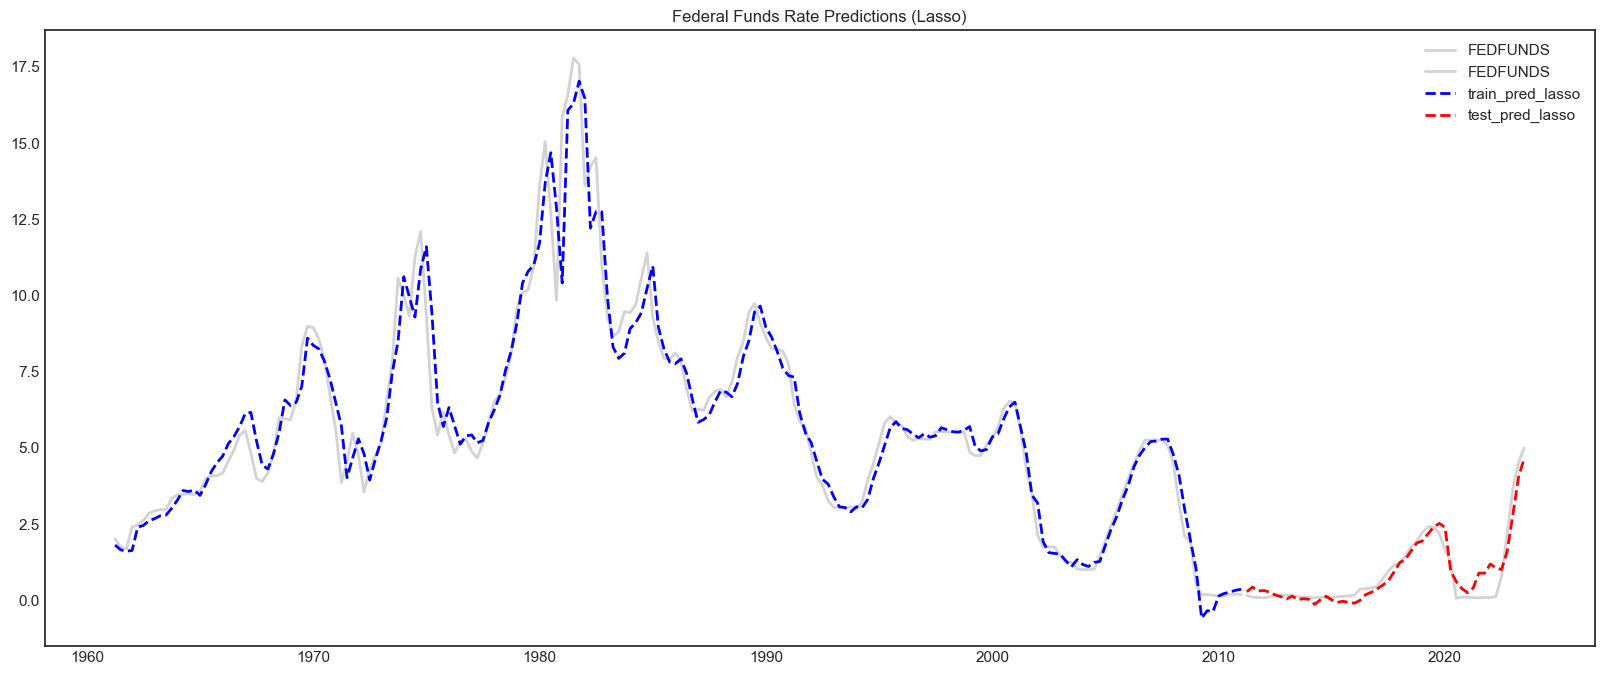

In [413]:
# Graph
fig, ax = plt.subplots(figsize=(20,8))
ax.xaxis.grid(False)

# Plot
ax.plot(train_df.index, train_df['FEDFUNDS'], 'lightgray', linewidth=2)
ax.plot(test_df.index, test_df['FEDFUNDS'], 'lightgray', linewidth=2)
ax.plot(train_pred_ols.index, train_pred_lasso, color='blue', linestyle='--', linewidth=2)
ax.plot(test_pred_ols.index, test_pred_lasso, color='red', linestyle='--', linewidth=2)

ax.legend(["FEDFUNDS", "FEDFUNDS","train_pred_lasso","test_pred_lasso"])
ax.set(title='Federal Funds Rate Predictions (Lasso)');

plt.show()

# LGBM

In [414]:
pipe_ltb = Pipeline(
    steps = [ ('preprocessor',preprocessor), ('model',ltb.LGBMRegressor())]
)

param_ltb = {
    'model__n_estimators': randint(100, 300), #[100, 200, 300],
    'model__learning_rate': uniform(0.01, 0.5),  #[0.01, 0.05, 0.1, 0.5],
    'model__max_depth': randint(3, 10),
    'model__num_leaves': randint(3, 60),
    'model__min_data_in_leaf' : randint(10, 20),
    'model__reg_alpha' : uniform(0.01, 0.1), 
    'model__verbose': [-1],
    'model__eval_metric': ['r2_score'],
}


cv = RandomizedSearchCV(estimator = pipe_ltb, 
                        param_distributions = param_ltb,
                        random_state=rand_int, 
                        scoring="r2")

cv.fit(X_train, y_train)
cv_results = cv.cv_results_['mean_test_score']
print('LGBMR', ') Best Accuracy Score:' , cv.best_score_ , 'Parameters: {}' , cv.best_params_)

LGBMR ) Best Accuracy Score: 0.4812685206483856 Parameters: {} {'model__eval_metric': 'r2_score', 'model__learning_rate': 0.08708142118983618, 'model__max_depth': 9, 'model__min_data_in_leaf': 11, 'model__n_estimators': 230, 'model__num_leaves': 6, 'model__reg_alpha': 0.08236018032921474, 'model__verbose': -1}


In [415]:
cv.best_estimator_

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imp_num',
                                                                   SimpleImputer())]),
                                                  ['gap_inf', 'gap_gdp',
                                                   'gap_ue',
                                                   'Real_Interest_Rate',
                                                   'CPIAUCSL_PC1', 'UNRATE',
                                                   'FEDFUNDS-1']),
                                                 ('cat',
                                                  Pipeline(steps=[('transformer',
                                                                   ColumnTransformer(transformers=[('onehotencoder',
                                                                                                    OneHotEncoder(categories=[[False,
                                                                                                                               True]],
                                                                                                                  drop='first',
                                                                                                                  handle_unknown='ignore',
                                                                                                                  sparse_output=False),
                                                                                                    ['recession_flag'])]))]),
                                                  ['recession_flag'])])),
                ('model',
                 LGBMRegressor(eval_metric='r2_score',
                               learning_rate=0.08708142118983618, max_depth=9,
                               min_data_in_leaf=11, n_estimators=230,
                               num_leaves=6, reg_alpha=0.08236018032921474,
                               verbose=-1))])

In [416]:
cv.best_estimator_.named_steps.model

LGBMRegressor(eval_metric='r2_score', learning_rate=0.08708142118983618,
              max_depth=9, min_data_in_leaf=11, n_estimators=230, num_leaves=6,
              reg_alpha=0.08236018032921474, verbose=-1)

In [417]:
train_pred_lgbm = cv.best_estimator_.predict(X_train, pred_contrib=False, raw_score=False)

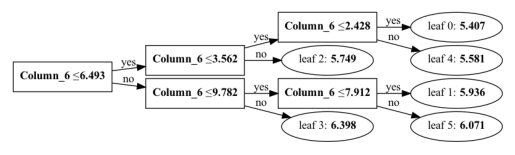

In [418]:
ltb.plot_tree(cv.best_estimator_.named_steps.model)
plt.show()

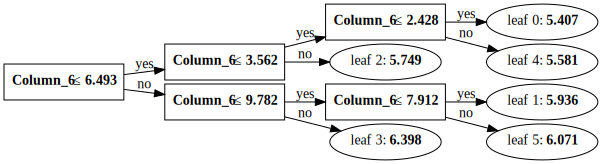

In [419]:
ltb.create_tree_digraph(cv.best_estimator_.named_steps.model)

In [420]:
feature_df = pd.DataFrame({'feature_name': cv.best_estimator_.named_steps.preprocessor.get_feature_names_out(),
                           'feature_importance': cv.best_estimator_.named_steps.model.feature_importances_})
feature_df.sort_values(by=['feature_importance'], key=pd.Series.abs , ascending=False , inplace=True)
feature_df

,feature_name,feature_importance
6,num__FEDFUNDS-1,262
1,num__gap_gdp,200
0,num__gap_inf,172
3,num__Real_Interest_Rate,164
2,num__gap_ue,125
4,num__CPIAUCSL_PC1,109
5,num__UNRATE,76
7,cat__onehotencoder__recession_flag_True,42


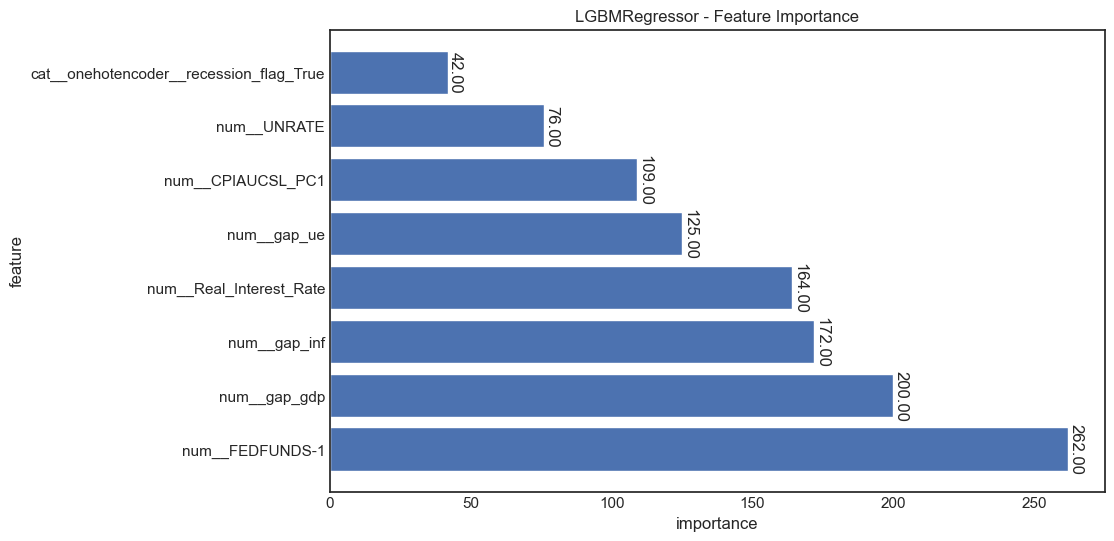

In [421]:
plt.figure(figsize=(10, 6))

bars = plt.barh(feature_df['feature_name'], feature_df['feature_importance'])
    
# Add vertical labels to the bars
for i, value in enumerate(feature_df['feature_importance']):
    plt.text(value, i, f'{value:.2f}', va='center', ha='left', rotation=-90)

    
plt.xlabel('importance')
plt.ylabel('feature')
plt.title('LGBMRegressor - Feature Importance')
plt.grid(False)
plt.show()

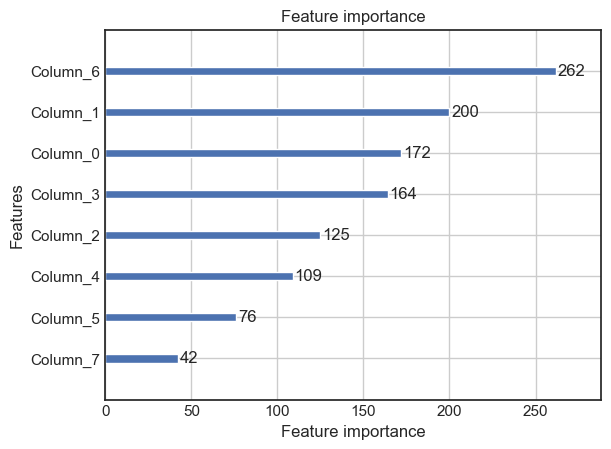

In [422]:
ltb.plot_importance(cv.best_estimator_.named_steps.model)
plt.show()

In [423]:
model_stats_df = model_results('lgbm_train', y_train, train_pred_lgbm, X_train.shape[0], X_train.shape[1] , model_stats_df )

## Test

In [424]:
test_pred_lgbm = cv.best_estimator_.predict(X_test, pred_contrib=False, raw_score=False)
test_pred_lgbm.shape

(50,)

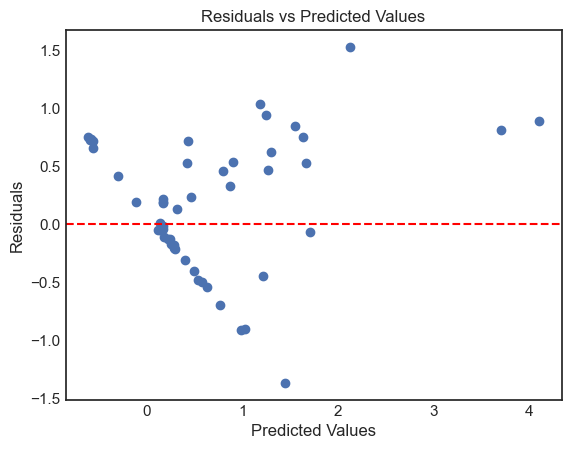

In [425]:
residuals = y_test - test_pred_lgbm
plt.scatter(test_pred_lgbm, residuals)
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs Predicted Values')
plt.axhline(y=0, color='red', linestyle='--')  # Add horizontal line at y=0 for reference
plt.show()

In [426]:
model_stats_df = model_results('lgbm_test', y_test, test_pred_lgbm, X_test.shape[0], X_test.shape[1] , model_stats_df )
model_stats_df

,name,r_sq,adj_r_sq,mse,rmse
0,ffef_tr_test,-1.1459,-1.1568,25.0445,5.0044
1,ffef_tr_test,-40.4673,-41.3312,56.7392,7.5325
2,ffef_tr2_test,0.9079,0.9074,1.0753,1.0369
3,ffef_tr2_test,0.7806,0.7760,0.3002,0.5479
4,Naive_test,0.9206,0.9206,0.9263,0.9624
5,Naive_test,0.8830,0.8830,0.1601,0.4002
6,ols_train,0.9401,0.9380,0.6986,0.8358
7,ols_test,0.8897,0.8713,0.1509,0.3885
8,lasso_train,0.9400,0.9397,0.7002,0.8368
9,lasso_test,0.8956,0.8782,0.1428,0.3780


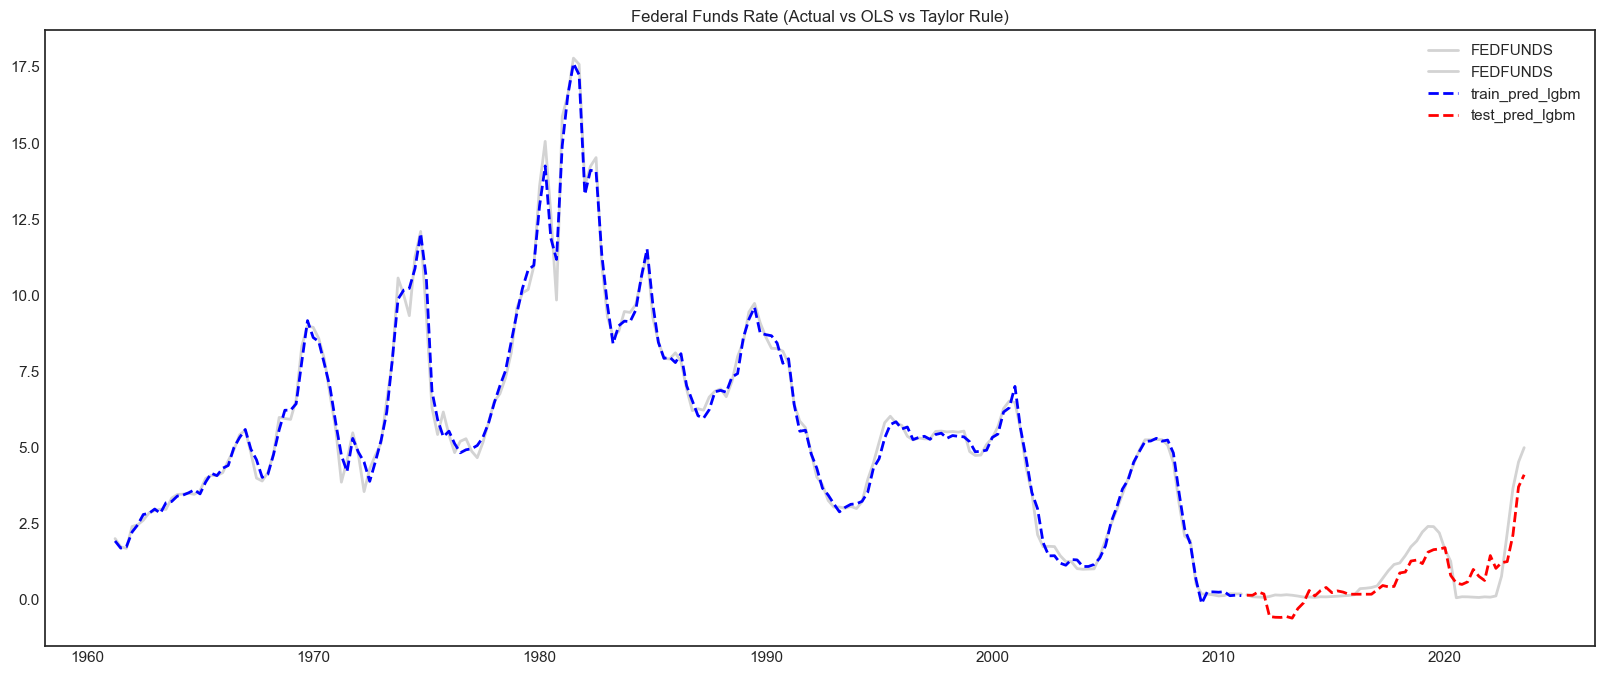

In [427]:
# Graph
fig, ax = plt.subplots(figsize=(20,8))
ax.xaxis.grid(False)

# Plot
ax.plot(train_df.index, train_df['FEDFUNDS'], 'lightgray', linewidth=2)
ax.plot(test_df.index, test_df['FEDFUNDS'], 'lightgray', linewidth=2)
ax.plot(X_train.index, train_pred_lgbm, color='blue', linestyle='--', linewidth=2)
ax.plot(X_test.index, test_pred_lgbm, color='red', linestyle='--', linewidth=2)
#ax.fill_between(test_pred_ols.index, test_pred_ols['mean_ci_lower'], test_pred_ols['mean_ci_upper'], alpha=0.20)
#ax.fill_between(test_pred_ols.index, test_pred_ols['obs_ci_lower'], test_pred_ols['obs_ci_upper'], alpha=0.15)

#ax.plot(taylor_df.index, taylor_df['ffef_tr'], 'orange', linestyle='--', linewidth=1)

ax.legend(["FEDFUNDS", "FEDFUNDS","train_pred_lgbm","test_pred_lgbm"])
ax.set(title='Federal Funds Rate (Actual vs OLS vs Taylor Rule)');
plt.show()

# Sharpe

In [428]:
#model = cv.best_estimator_.named_steps.model.fit(X_train_trf, y_train)
model = cv.best_estimator_.named_steps.model
model

LGBMRegressor(eval_metric='r2_score', learning_rate=0.08708142118983618,
              max_depth=9, min_data_in_leaf=11, n_estimators=230, num_leaves=6,
              reg_alpha=0.08236018032921474, verbose=-1)

In [429]:
explainer = None
shap_values = None

In [430]:
try:
    explainer = shap.Explainer(model, X_train_trf, check_additivity=False)
    shap_values = explainer(X_train_trf, check_additivity=False)
except Exception as e:
    print('-- error ')
    print(e)

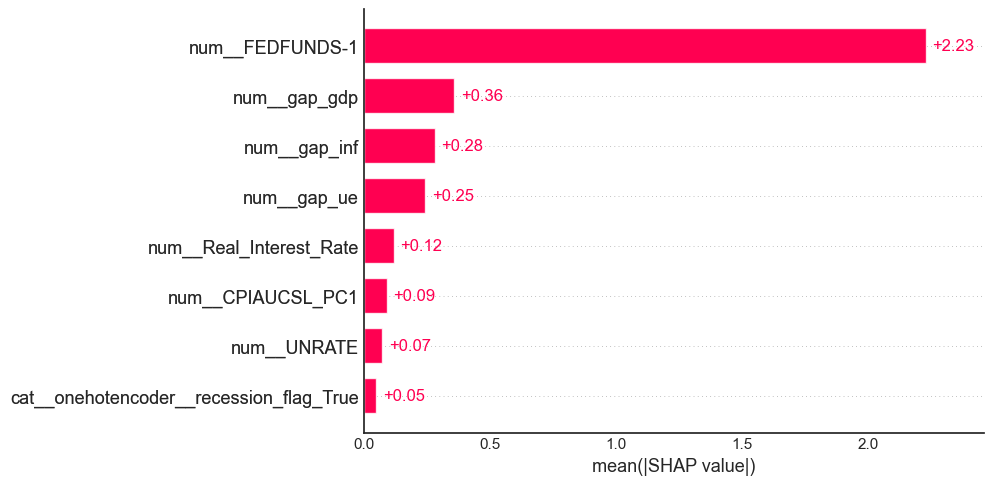

In [431]:
if (shap_values is not None):
    shap.plots.bar(shap_values, max_display=20)

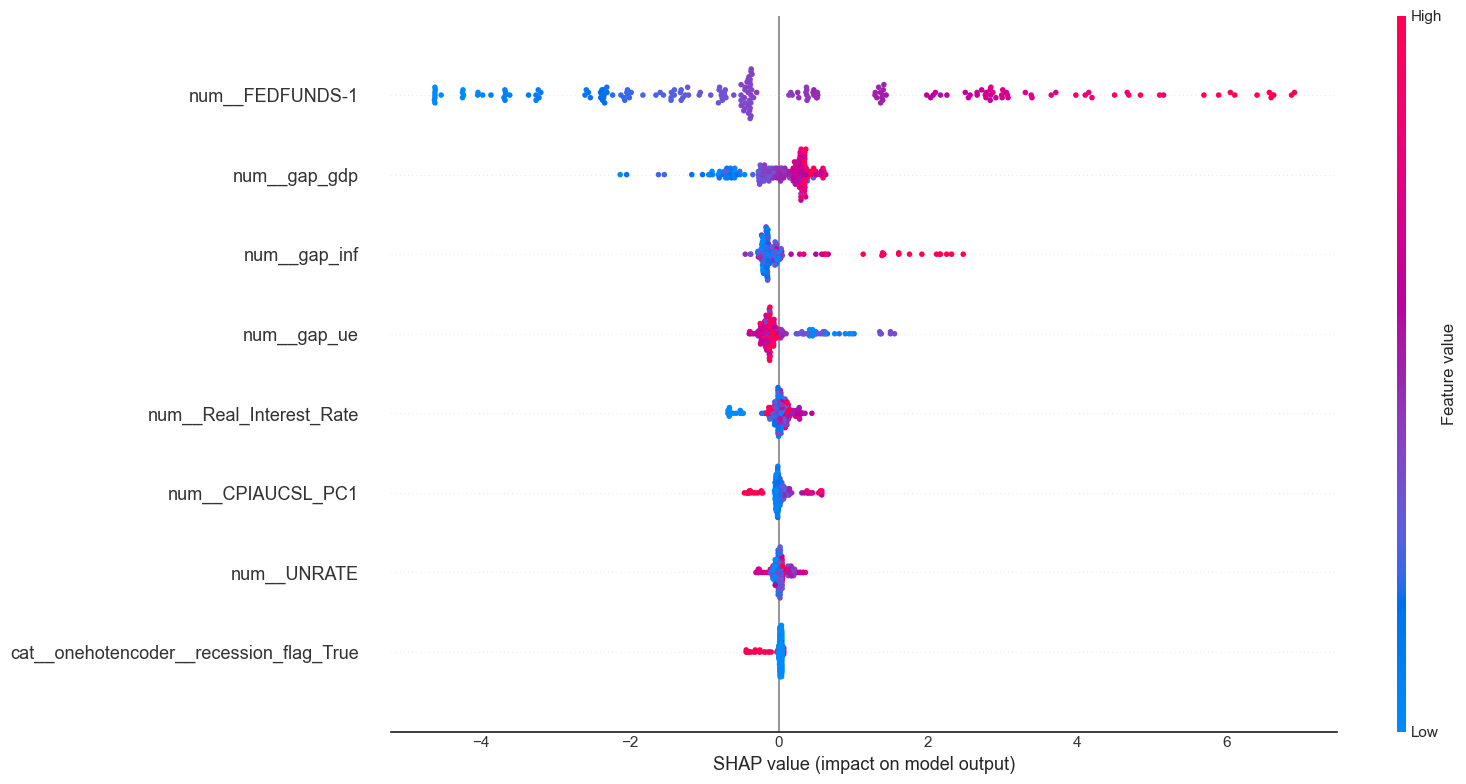

In [432]:
if (shap_values is not None):
    shap.summary_plot(shap_values, X_train_trf, plot_size=(16,8))

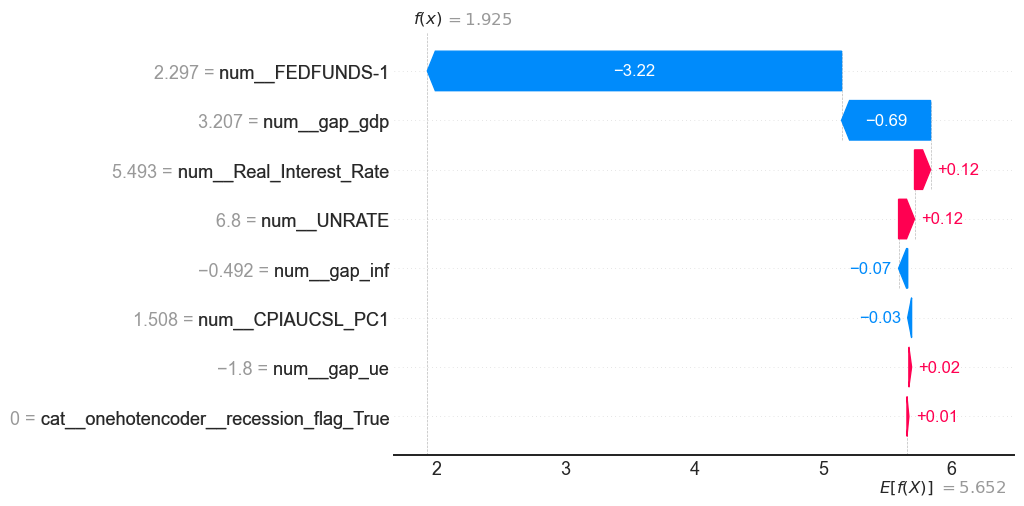

In [433]:
if (shap_values is not None):
    shap.plots.waterfall(shap_values[0], max_display=20)


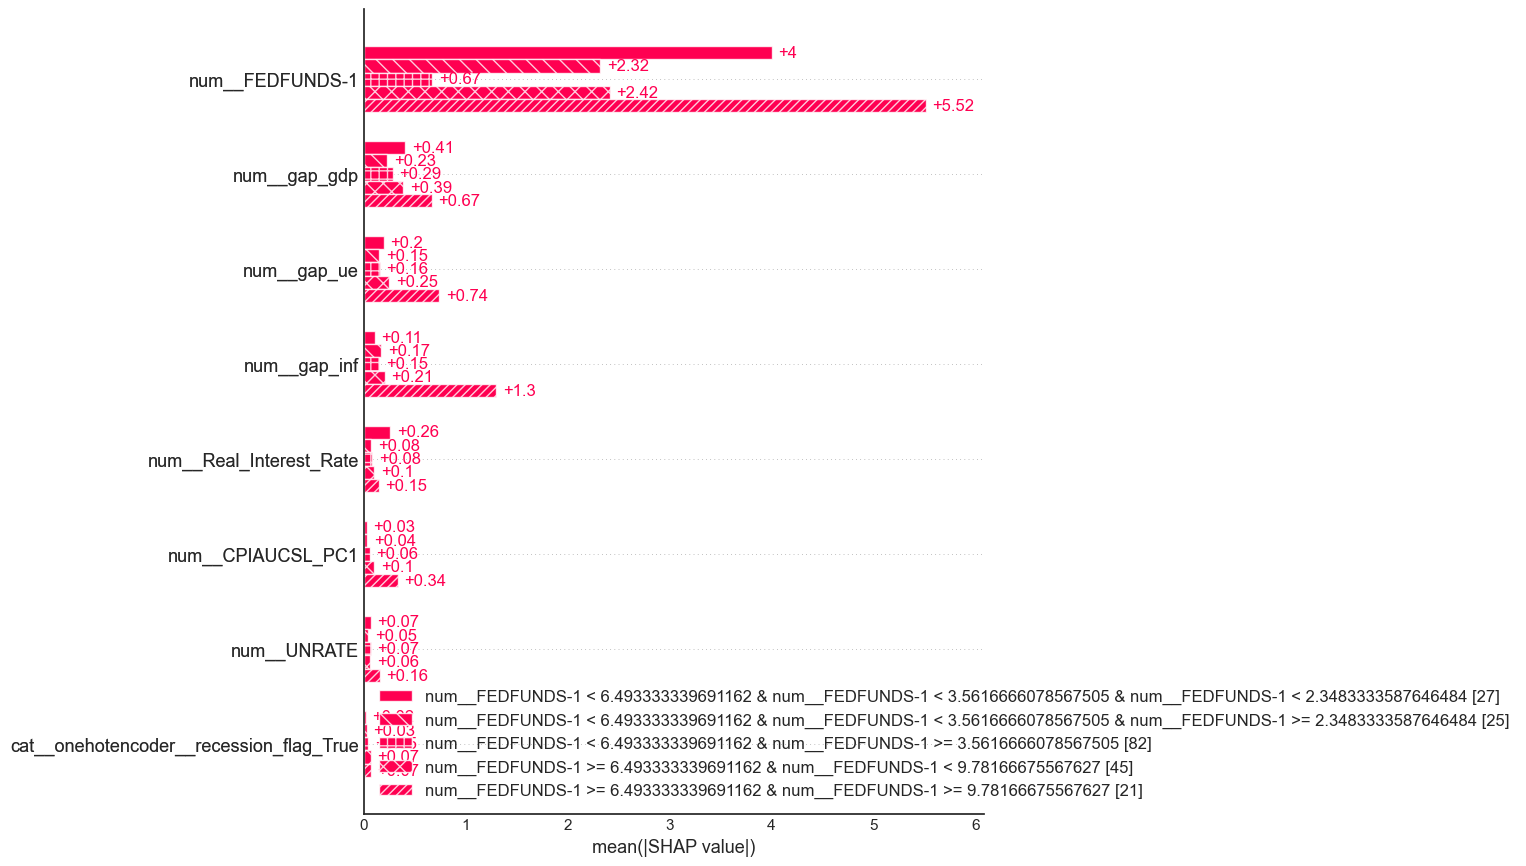

In [434]:
if (shap_values is not None):
    shap.plots.bar(shap_values.cohorts(5).abs.mean(0),  max_display=10)